# Simulate the Boutilier Coordination Game

In [1]:
from environment import Boutilier
from agent import RandomAgent, QLearner, TDLearner
from HystereticQLearner import HystereticQLearner
from policy import epsilon_greedy
from boltzmann import selection as softmax
from utils import simulate_task, find_greedy_action_for_state
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed()

# Rewards

In [2]:
def boutilier_factory(k, key):
    if(key == "part stochastic"):
        return Boutilier(k, True)
    elif (key == "deterministic"):
        return Boutilier(k)
    else:
        print(f"Unknown key: {key}")

In [3]:
def agent_factory(cls, task, *args):
    # Use kwargs to be a better factory.
    if(cls == "hysteretic"):
        return HystereticQLearner(task, *args)
    elif(cls == "q-learning"):
        return QLearner(task, *args)
    elif(cls == "random"):
        return RandomAgent(task)
    else:
        print(f"Unkown class: {cls}")

In [4]:
def simulate_boutilier(k, key, learning_steps, sim_number, player_one_cls="hysteretic", player_two_cls="hysteretic"):
    exploration_rate = None

    def discount_rate(_):
        return 0.9

    def learning_rate(_):
        return 0.1

    temperature_start = None  # Replace T = num with T = temperature_start maybe?
    policy = epsilon_greedy(0.05)

    num_converge = 0
    num_six = 0
    timesteps = learning_steps * 2

    if (sim_number % 100) == 0:
        print(f"| Simulation {sim_number} for k={k} key={key} |")

    # Initialize task and agents
    task = boutilier_factory(k, key)
    if key == "part stochastic":
        decrease_rate = lambda _: 0.05
    elif key == "deterministic":
        decrease_rate = lambda _: 0.01
    else:
        print(f"UNKNOWN key {key}")

    agents = [
        agent_factory(
            player_one_cls,
            task,
            exploration_rate,
            learning_rate,
            discount_rate,
            decrease_rate,
            policy,
        ),
        agent_factory(
            player_two_cls,
            task,
            exploration_rate,
            learning_rate,
            discount_rate,
            decrease_rate,
            policy,
        ),
    ]

    sim_rewards = np.zeros(learning_steps)

    t = 0
    T = temperature_start
    for j in range(learning_steps):
        # Learning step
        for agent in agents:
            if isinstance(agent, TDLearner):
                agent.policy = policy
            
        task = boutilier_factory(k, key)

        t, T = simulate_task(agents, task, t, T, timesteps=timesteps)

        # after each learning step, perform a greedy step
        task = boutilier_factory(k, key)
        agents[0].accumulated_reward = 0
        for agent in agents:
            if isinstance(agent, TDLearner):
                agent.policy = epsilon_greedy(0)

        _, _, acc_reward = simulate_task(
            agents,
            task,
            0,
            T,
            timesteps=timesteps,
            update_agents=False,
            return_acc_reward=True,
        )

        sim_rewards[j] = acc_reward

        agents[0].accumulated_reward = 0

    return {"k": k, "key": key, "data": sim_rewards, "sim_number": sim_number}

In [5]:
%%time
import concurrent.futures

rewards = {}
rewards["deterministic"] = {}
rewards["part stochastic"] = {}

learning_steps = 10000
num_simulations = 200
rewards["deterministic"]["k=0"] = np.zeros((num_simulations, learning_steps))
rewards["deterministic"]["k=-100"] = np.zeros((num_simulations, learning_steps))
rewards["part stochastic"]["k=0"] = np.zeros((num_simulations, learning_steps))
rewards["part stochastic"]["k=-100"] = np.zeros((num_simulations, learning_steps))

with concurrent.futures.ProcessPoolExecutor() as executor:
    keys = ["part stochastic", "deterministic"]
    k_val = [-100, 0]

    results = [
        executor.submit(simulate_boutilier, k, key, learning_steps, sim_number)
        for key in keys
        for k in k_val
        for sim_number in range(num_simulations)
    ]

    for f in concurrent.futures.as_completed(results):
        obj = f.result()
        rewards[obj["key"]][f"k={obj['k']}"][obj["sim_number"]] = obj["data"]

| Simulation 0 for k=-100 key=part stochastic |
| Simulation 100 for k=-100 key=part stochastic |
| Simulation 0 for k=0 key=part stochastic |
| Simulation 100 for k=0 key=part stochastic |
| Simulation 0 for k=-100 key=deterministic |
| Simulation 100 for k=-100 key=deterministic |
| Simulation 0 for k=0 key=deterministic |
| Simulation 100 for k=0 key=deterministic |
CPU times: user 532 ms, sys: 181 ms, total: 713 ms
Wall time: 7min 24s


# Decentralized

In [6]:
%%time
## broken for decentralized. No need to fix at the moment.
import concurrent.futures

q_rewards = {}
q_rewards["deterministic"] = {}
q_rewards["part stochastic"] = {}

learning_steps = 10000
num_simulations = 200
q_rewards["deterministic"]["k=0"] = np.zeros((num_simulations, learning_steps))
q_rewards["deterministic"]["k=-100"] = np.zeros((num_simulations, learning_steps))
q_rewards["part stochastic"]["k=0"] = np.zeros((num_simulations, learning_steps))
q_rewards["part stochastic"]["k=-100"] = np.zeros((num_simulations, learning_steps))

with concurrent.futures.ProcessPoolExecutor() as executor:
    keys = ["part stochastic", "deterministic"]
    k_val = [-100, 0]

    results = [
        executor.submit(simulate_boutilier, k, key, learning_steps, sim_number, "q-learning", "q-learning")
        for key in keys
        for k in k_val
        for sim_number in range(num_simulations)
    ]

    for f in concurrent.futures.as_completed(results):
        obj = f.result()
        q_rewards[obj["key"]][f"k={obj['k']}"][obj["sim_number"]] = obj["data"]

| Simulation 0 for k=-100 key=part stochastic |
| Simulation 100 for k=-100 key=part stochastic |
| Simulation 0 for k=0 key=part stochastic |
| Simulation 100 for k=0 key=part stochastic |
| Simulation 0 for k=-100 key=deterministic |
| Simulation 100 for k=-100 key=deterministic |
| Simulation 0 for k=0 key=deterministic |
| Simulation 100 for k=0 key=deterministic |


TypeError: QLearner.__init__() takes from 5 to 6 positional arguments but 7 were given

# Random agents

In [7]:
%%time
import concurrent.futures

random_rewards_1 = {}
random_rewards_1["deterministic"] = {}
random_rewards_1["part stochastic"] = {}

learning_steps = 10000
num_simulations = 200
random_rewards_1["deterministic"]["k=0"] = np.zeros((num_simulations, learning_steps))
random_rewards_1["deterministic"]["k=-100"] = np.zeros((num_simulations, learning_steps))
random_rewards_1["part stochastic"]["k=0"] = np.zeros((num_simulations, learning_steps))
random_rewards_1["part stochastic"]["k=-100"] = np.zeros((num_simulations, learning_steps))


random_rewards_2 = {}
random_rewards_2["deterministic"] = {}
random_rewards_2["part stochastic"] = {}

random_rewards_2["deterministic"]["k=0"] = np.zeros((num_simulations, learning_steps))
random_rewards_2["deterministic"]["k=-100"] = np.zeros((num_simulations, learning_steps))
random_rewards_2["part stochastic"]["k=0"] = np.zeros((num_simulations, learning_steps))
random_rewards_2["part stochastic"]["k=-100"] = np.zeros((num_simulations, learning_steps))


with concurrent.futures.ProcessPoolExecutor() as executor:
    keys = ["part stochastic", "deterministic"]
    k_val = [-100, 0]

    results = [
        executor.submit(simulate_boutilier, k, key, learning_steps, sim_number, "hysteretic", "random")
        for key in keys
        for k in k_val
        for sim_number in range(num_simulations)
    ]

    results_2 = [
        executor.submit(simulate_boutilier, k, key, learning_steps, sim_number, "random", "hysteretic")
        for key in keys
        for k in k_val
        for sim_number in range(num_simulations)
    ]
        
    for f in concurrent.futures.as_completed(results):
        obj = f.result()
        random_rewards_1[obj["key"]][f"k={obj['k']}"][obj["sim_number"]] = obj["data"]
        
        
    for f in concurrent.futures.as_completed(results_2):
        obj = f.result()
        random_rewards_2[obj["key"]][f"k={obj['k']}"][obj["sim_number"]] = obj["data"]

| Simulation 0 for k=-100 key=part stochastic |
| Simulation 100 for k=-100 key=part stochastic |
| Simulation 0 for k=0 key=part stochastic |
| Simulation 100 for k=0 key=part stochastic |
| Simulation 0 for k=-100 key=deterministic |
| Simulation 100 for k=-100 key=deterministic |
| Simulation 0 for k=0 key=deterministic |
| Simulation 100 for k=0 key=deterministic |
| Simulation 0 for k=-100 key=part stochastic |
| Simulation 100 for k=-100 key=part stochastic |
| Simulation 0 for k=0 key=part stochastic |
| Simulation 100 for k=0 key=part stochastic |
| Simulation 0 for k=-100 key=deterministic |
| Simulation 100 for k=-100 key=deterministic |
| Simulation 0 for k=0 key=deterministic |
| Simulation 100 for k=0 key=deterministic |
CPU times: user 1.13 s, sys: 404 ms, total: 1.54 s
Wall time: 11min 14s


# Graph

In [31]:
import numpy as np
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


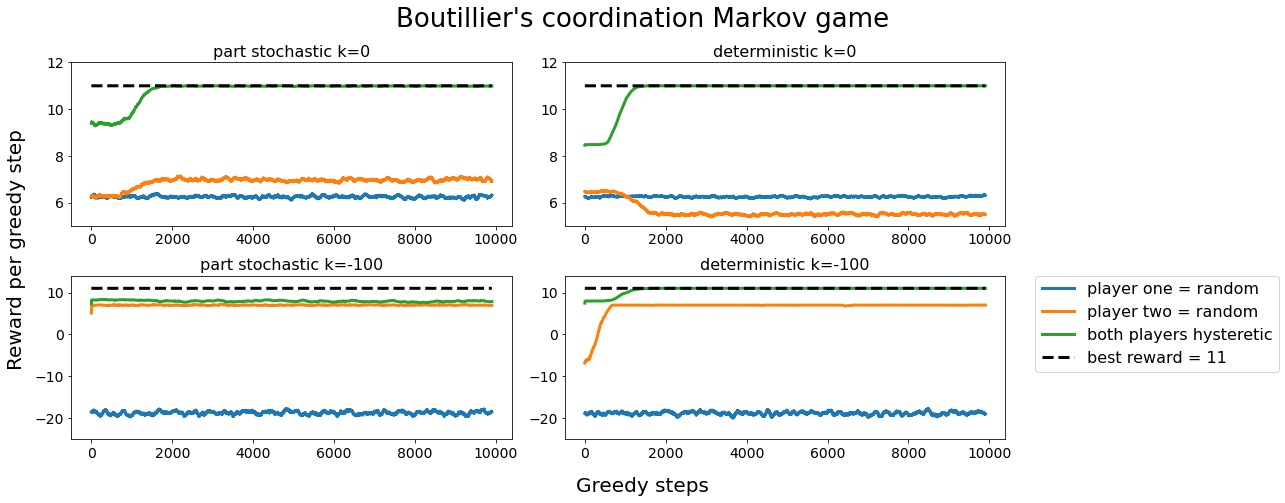

In [64]:
# fig = plt.figure(figsize=(16,6))
keys = ["part stochastic", "deterministic"]
k_vals = [0, -100]

# keys = ["part stochastic"]
# k_vals = [0]

fig, axs = plt.subplots(2, 2, figsize=(18, 7) )

for i in range(len(keys)):
    for j in range(len(k_vals)):
        key = keys[i]
        k = k_vals[j]
        ax = axs[j][i]
        
        x = np.array(range(10000))
#         for data in rewards[key]["k={}".format(k)]:
#             data = rewards["deterministic"]["k=0"]
#             ax.plot(x, data, alpha=0.05, color='orange')
            
        ax.plot(moving_average(np.average(random_rewards_2[key]["k={}".format(k)], axis=0), 100), lw =3, label='player one = random')
        ax.plot(moving_average(np.average(random_rewards_1[key]["k={}".format(k)], axis=0), 100), lw=3, label='player two = random')
        ax.plot(moving_average(np.mean(rewards[key]["k={}".format(k)], axis=0), 100), lw=3, label='both players hysteretic')
        
        # moving average
        #       ax.set_xscale('log')

        ax.plot(moving_average(np.repeat(11, 10000), 100), '--', lw=3, label='best reward = 11', color='black')
        ax.set_title("{} k={}".format(key, k), fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
        
        if(j == 1):
            ax.set_ylim(-25, 14)
        else:
            ax.set_ylim(5, 12)
        if(j == 1 and i == 1):
            ax.legend(fontsize=16, bbox_to_anchor=(1.05, 1.05))
            
        # plt.plot(range(5000), np.repeat(7.62, 5000), '--', lw=3, label='line', color='green')

fig.suptitle('Boutillier\'s coordination Markov game', fontsize=26)
fig.supxlabel('Greedy steps',  fontsize=20)
fig.supylabel('Reward per greedy step', x=0.01, fontsize=20, )

parameters_text = r'$\alpha = 0.1,\gamma=0.9,\epsilon=0.05, \beta=0.01$ in deterministic games and $\beta=0.05$ in stochastic games'
# plt.figtext(0.1, -0.035,s="Averaged over 200 trials with {}. Best possible reward is 11.".format(parameters_text), fontsize=13)
fig.tight_layout()
# plt.ylim(-30, 12)
plt.savefig('boutilier_rewards_v2.png')

# Save data

In [11]:
import pickle
from copy import deepcopy
filename = f'boutillier_player_{}.pickle'
outfile = open(filename,'wb')
pickle.dump(deepcopy(random_rewards_2), outfile)
outfile.close()

In [4]:
import pickle
filename = 'boutillier_player_{}.pickle'
infile = open(filename,'rb')
random_rewards_2 = pickle.load(infile)
infile.close()